In [1]:
!pwd

/reg/data/ana03/scratch/cwang31/spi


In [2]:
# Load paths for using psana
%env SIT_ROOT=/reg/g/psdm/
%env SIT_DATA=/cds/group/psdm/data/
%env SIT_PSDM_DATA=/cds/data/psdm/

env: SIT_ROOT=/reg/g/psdm/
env: SIT_DATA=/cds/group/psdm/data/
env: SIT_PSDM_DATA=/cds/data/psdm/


In [3]:
import os
import logging
import torch
import socket
import pickle
import tqdm

from deepprojection.datasets.lite    import SPIDataset         , SPIOnlineDataset
from deepprojection.model            import OnlineSiameseModel , ConfigSiameseModel
from deepprojection.trainer          import OnlineTrainer      , ConfigTrainer
from deepprojection.validator        import OnlineLossValidator, ConfigValidator
from deepprojection.encoders.convnet import Hirotaka0122       , ConfigEncoder
from deepprojection.utils            import EpochManager       , MetaLog, init_logger, split_dataset
from datetime import datetime
from image_preprocess import DatasetPreprocess

# [[[ CONFIG ]]]
timestamp_prev = None
frac_train = 0.25
frac_validate = 0.5

lr = 1e-3
alpha = 2.0
seed = 0

size_sample_train = 1000
size_sample_validate = 1000
size_sample_per_class = None
size_batch = 200
online_shuffle = True
trans = None

# [[[ LOGGING ]]]
timestamp = init_logger(returns_timestamp = True)

# Clarify the purpose of this experiment...
hostname = socket.gethostname()
comments = f"""
            Hostname: {hostname}.

            Online training.

            Sample size (train)     : {size_sample_train}
            Sample size (validate)  : {size_sample_validate}
            Sample size (per class) : {size_sample_per_class}
            Batch  size             : {size_batch}
            Alpha                   : {alpha}
            Online shuffle          : {online_shuffle}
            lr                      : {lr}

            """


# [[[ DATASET ]]]
# Set up parameters for an experiment...
drc_dataset   = 'fastdata'
fl_dataset    = '0000.fastdata'    # Raw, just give it a try
path_dataset  = os.path.join(drc_dataset, fl_dataset)

# Load raw data...
with open(path_dataset, 'rb') as fh:
    dataset_list = pickle.load(fh)

# Split data...
data_train   , data_val_and_test = split_dataset(dataset_list     , frac_train   , seed = seed)
data_validate, data_test         = split_dataset(data_val_and_test, frac_validate, seed = seed)

# Define the training set
dataset_train = SPIOnlineDataset( dataset_list = data_train, 
                                  size_sample  = size_sample_train,
                                  size_sample_per_class = size_sample_per_class, 
                                  trans = trans, 
                                  seed  = seed, )

# Define the training set
dataset_validate = SPIOnlineDataset( dataset_list = data_validate, 
                                     size_sample  = size_sample_train,
                                     size_sample_per_class = size_sample_per_class, 
                                     trans = trans, 
                                     seed  = seed, )

In [4]:
for i, item in enumerate(dataset_validate):
    if i > 10: break
    print(item[2])

('amo06516', '96', ' 83664', '2')
('amo06516', '90', ' 15919', '2')
('amo06516', '90', ' 22752', '1')
('amo06516', '96', ' 10330', '0')
('amo06516', '90', ' 44983', '1')
('amo06516', '96', '  6689', '1')
('amo06516', '90', ' 43567', '2')
('amo06516', '91', ' 10534', '0')
('amo06516', '90', ' 21424', '1')
('amo06516', '96', '183144', '1')
('amo06516', '96', ' 83664', '2')


In [5]:
for i, item in enumerate(dataset_validate):
    if i > 10: break
    print(item[2])

('amo06516', '96', ' 83664', '2')
('amo06516', '90', ' 15919', '2')
('amo06516', '90', ' 22752', '1')
('amo06516', '96', ' 10330', '0')
('amo06516', '90', ' 44983', '1')
('amo06516', '96', '  6689', '1')
('amo06516', '90', ' 43567', '2')
('amo06516', '91', ' 10534', '0')
('amo06516', '90', ' 21424', '1')
('amo06516', '96', '183144', '1')
('amo06516', '96', ' 83664', '2')


In [6]:
dataset_train[0]

(array([[[-0.10398383,  0.03491898, -0.09542035, ..., -0.00073364,
          -0.07698455,  0.0912585 ],
         [-0.14891362,  0.01378856, -0.10509702, ...,  0.10408345,
          -0.0161233 ,  0.10839733],
         [-0.09408585, -0.05527322, -0.04292893, ...,  0.00649507,
          -0.08572904,  0.15818281],
         ...,
         [ 0.10999746, -0.06048281, -0.00281666, ..., -0.0639746 ,
          -0.00759374, -0.05091143],
         [ 0.07487232, -0.03977283, -0.07455577, ..., -0.11376868,
           0.03963405, -0.03528195],
         [ 0.05793897, -0.05693524, -0.07272473, ..., -0.09021135,
          -0.04231576,  0.01261501]]], dtype=float32),
 2,
 ('amo06516', '94', ' 24848', '2'))

### Preprocess

In [4]:
# Preprocess dataset...
# Data preprocessing can be lengthy and defined in dataset_preprocess.py
img_orig            = dataset_train[0][0][0]   # idx, fetch img
dataset_preproc     = DatasetPreprocess(img_orig)
trans               = dataset_preproc.config_trans()
dataset_train.trans = trans
dataset_validate.trans = trans
img_trans           = dataset_train[0][0][0]

#### Just checking

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.figure(figsize = (15, 12))
data = img_orig
vmin = data.mean()
vmax = vmin + 1 * data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)
plt.colorbar()

In [ ]:
plt.figure(figsize = (15, 12))
data = dataset_train[134][0][0]
vmin = data.mean()
vmax = vmin + 1 * data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)
plt.colorbar()

### Load model

In [6]:
# [[[ IMAGE ENCODER ]]]
# Config the encoder...
dim_emb        = 128
size_y, size_x = img_trans.shape[-2:]
config_encoder = ConfigEncoder( dim_emb = dim_emb,
                                size_y  = size_y,
                                size_x  = size_x,
                                isbias  = True )
encoder = Hirotaka0122(config_encoder)


# [[[ MODEL ]]]
# Config the model...
config_siamese = ConfigSiameseModel( alpha = alpha, encoder = encoder, )
model = OnlineSiameseModel(config_siamese)
model.init_params(from_timestamp = timestamp_prev)

### Config trainer and validator

In [7]:
# [[[ CHECKPOINT ]]]
drc_cwd          = os.getcwd()
DRCCHKPT         = "chkpts"
prefixpath_chkpt = os.path.join(drc_cwd, DRCCHKPT)
fl_chkpt         = f"{timestamp}.train.chkpt"
path_chkpt       = os.path.join(prefixpath_chkpt, fl_chkpt)


# [[[ TRAINER ]]]
# Config the trainer...
config_train = ConfigTrainer( path_chkpt     = path_chkpt,
                              num_workers    = 1,
                              batch_size     = size_batch,
                              pin_memory     = True,
                              shuffle        = False,
                              is_logging     = False,
                              online_shuffle = online_shuffle,
                              method         = 'random-semi-hard', 
                              lr             = lr, 
                              tqdm_disable   = True)

# Training...
trainer = OnlineTrainer(model, dataset_train, config_train)


# [[[ VALIDATOR ]]]
config_validator = ConfigValidator( path_chkpt     = None,
                                    num_workers    = 1,
                                    batch_size     = size_batch,
                                    pin_memory     = True,
                                    shuffle        = False,
                                    is_logging     = False,
                                    online_shuffle = online_shuffle,
                                    method         = 'random-semi-hard', 
                                    lr             = lr,
                                    tqdm_disable   = True)  # Conv2d input needs one more dim for batch
validator = OnlineLossValidator(model, dataset_validate, config_validator)

### Training epochs

In [8]:
loss_train_hist = []
loss_validate_hist = []
loss_min_hist = []

# [[[ EPOCH MANAGER ]]]
epoch_manager = EpochManager( trainer   = trainer,
                              validator = validator,
                              timestamp = timestamp, )

# epoch_manager.set_layer_to_capture(
#     module_name_capture_list  = ["final_conv"],
#     module_layer_capture_list = [torch.nn.ReLU],
# )

In [ ]:
max_epochs = 200
freq_save = 5
for epoch in tqdm.tqdm(range(max_epochs), disable=False):
    loss_train, loss_validate, loss_min = epoch_manager.run_one_epoch(epoch = epoch, returns_loss = True)
    
    loss_train_hist.append(loss_train)
    loss_validate_hist.append(loss_validate)
    loss_min_hist.append(loss_min)

    # if epoch % freq_save == 0: 
    #     epoch_manager.save_model_parameters()
    #     epoch_manager.save_model_gradients()
    #     epoch_manager.save_state_dict()

 26%|██▋       | 53/200 [04:19<11:58,  4.89s/it]

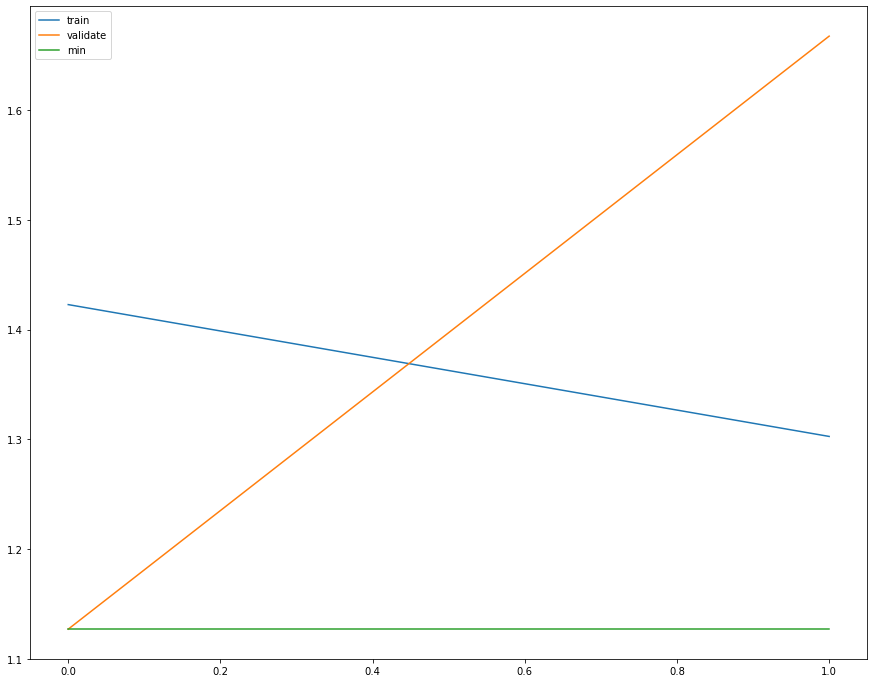

In [12]:
plt.figure(figsize = (15, 12))
x = range(len(loss_train_hist))
y = loss_train_hist
plt.plot(x, y, label = 'train')

x = range(len(loss_validate_hist))
y = loss_validate_hist
plt.plot(x, y, label = 'validate')

x = range(len(loss_min_hist))
y = loss_min_hist
plt.plot(x, y, label = 'min')

plt.legend()

### Test

In [18]:
from deepprojection.datasets.lite import MultiwayQueryset
from deepprojection.model import SiameseModelCompare
from deepprojection.validator import MultiwayQueryValidator

# Define the test set
size_sample_test = 1000
size_sample_per_class = None
size_batch = 100
online_shuffle = True
dataset_test = MultiwayQueryset( dataset_list = data_test, 
                                 size_sample  = size_sample_test,
                                 size_sample_per_class = size_sample_per_class, 
                                 trans = trans, 
                                 seed  = seed, )

# Set up the model
timestamp_test = timestamp
## timestamp_test = "2022_1114_0123_11"
config_siamese_test = ConfigSiameseModel( encoder = encoder, )
model_test = SiameseModelCompare(config_siamese_test)
model_test.init_params(from_timestamp = timestamp_test)

In [ ]:
plt.figure(figsize = (15, 12))
data = dataset_test[1][0][0]
vmin = data.mean()
vmax = vmin + 1 * data.std()
plt.imshow(data, vmin = vmin, vmax = vmax)
plt.colorbar()

In [19]:
config_tester = ConfigValidator( num_workers = 1,
                                    batch_size  = size_batch,
                                    pin_memory  = True,
                                    shuffle     = False,
                                    isflat      = False,
                                    lr          = lr, )

tester = MultiwayQueryValidator(model_test, dataset_test, config_tester)
batch_metadata_query_list, batch_metadata_support_list, batch_dist_support_list = tester.validate(returns_details = True)

100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


#### Distribution of embedding distances

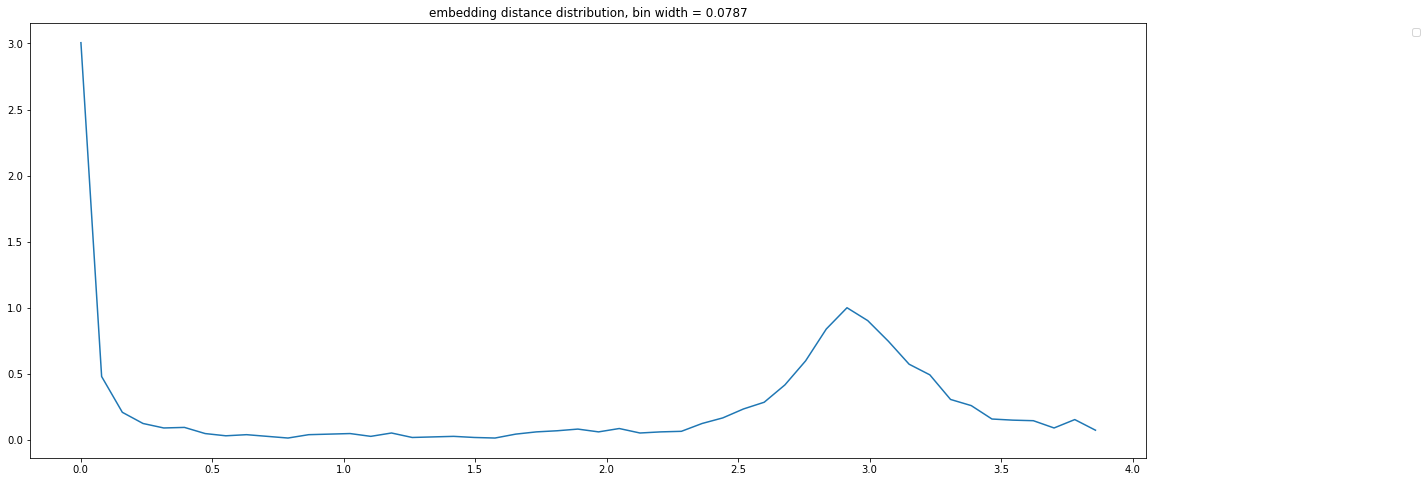

In [31]:
import numpy as np

hy, hx = np.histogram(batch_dist_support_list, bins = 50, density = True)

plt.figure( figsize = (20, 8) )
plt.plot(hx[:-1], hy)
plt.legend(bbox_to_anchor=(1.25, 1.00));
plt.title(f'embedding distance distribution, bin width = {hx[1]-hx[0]:.4f}');

In [34]:
np.sum(hy * (hx[1:] - hx[:-1]))    # Density means sum of bin_frequency_density * bin_width.

1.0

#### Confusion matrix

##### Focus on min embedding distance

In [21]:
import numpy as np
idx_min_value_list = np.argmin(batch_dist_support_list, axis = 1)
idx_min_value_list.shape

(10, 100)

In [66]:
min_value_list = np.min(batch_dist_support_list, axis = 1)
min_value_list.shape

(10, 100)

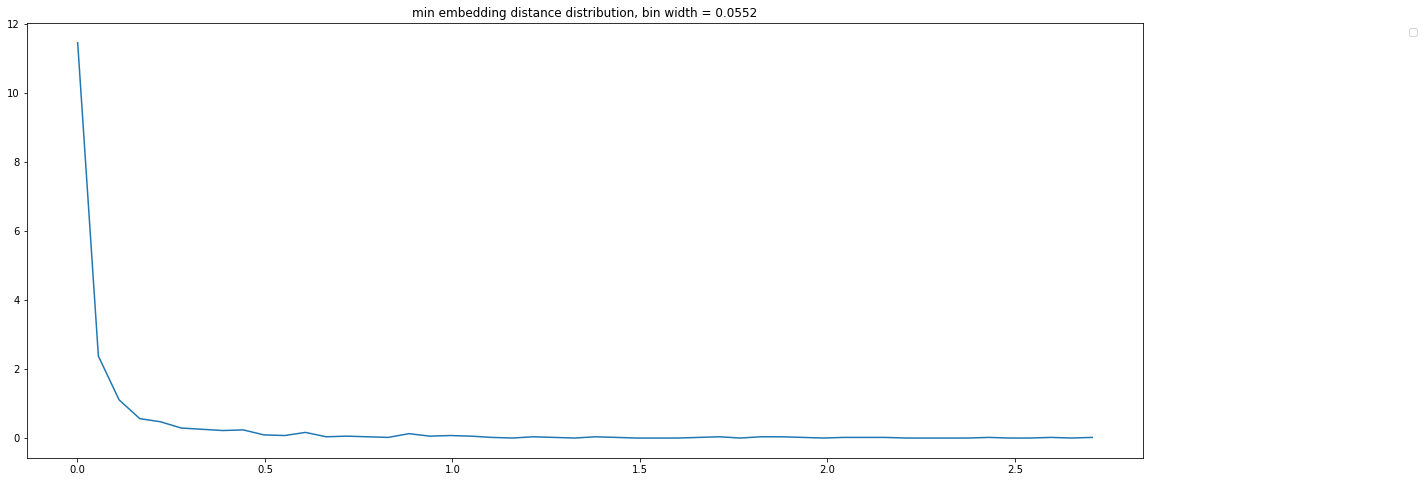

In [67]:
import numpy as np

hy, hx = np.histogram(min_value_list, bins = 50, density = True)

plt.figure( figsize = (20, 8) )
plt.plot(hx[:-1], hy)
plt.legend(bbox_to_anchor=(1.25, 1.00));
plt.title(f'min embedding distance distribution, bin width = {hx[1]-hx[0]:.4f}');

Total events = 8


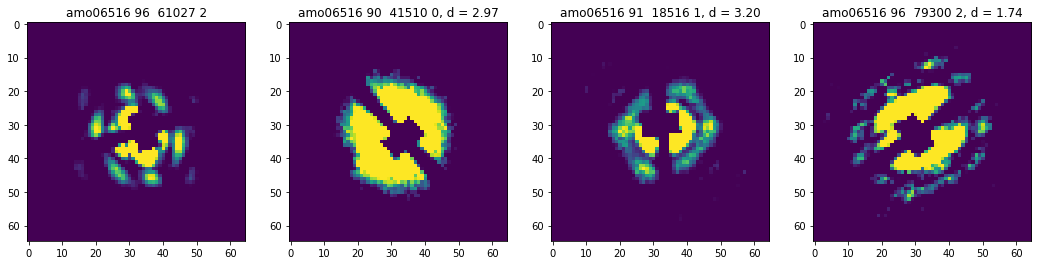

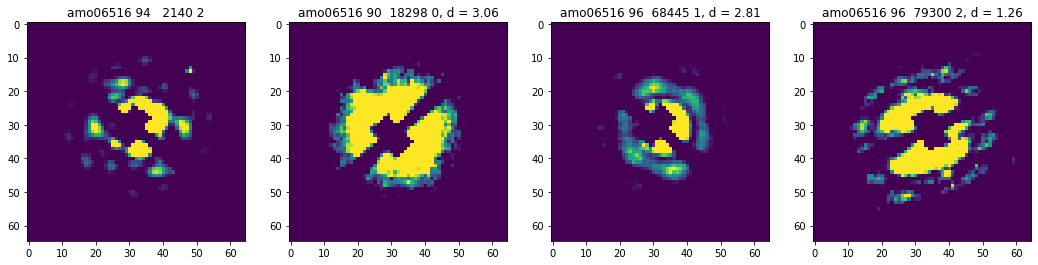

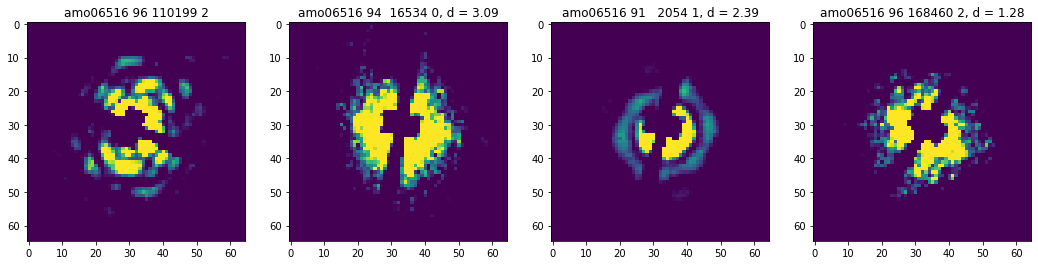

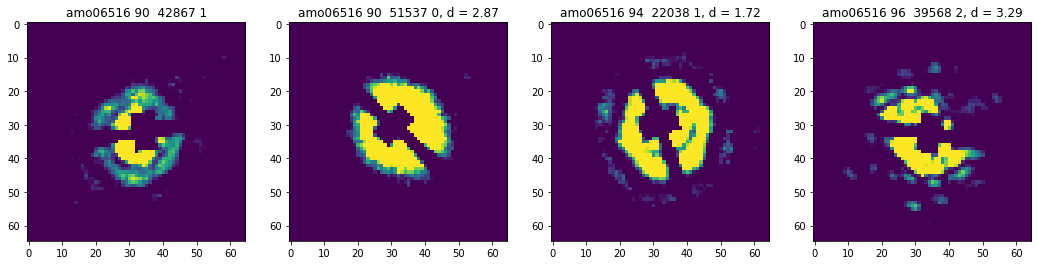

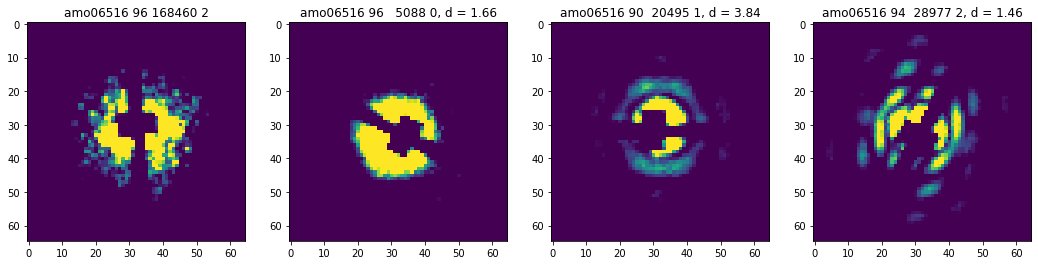

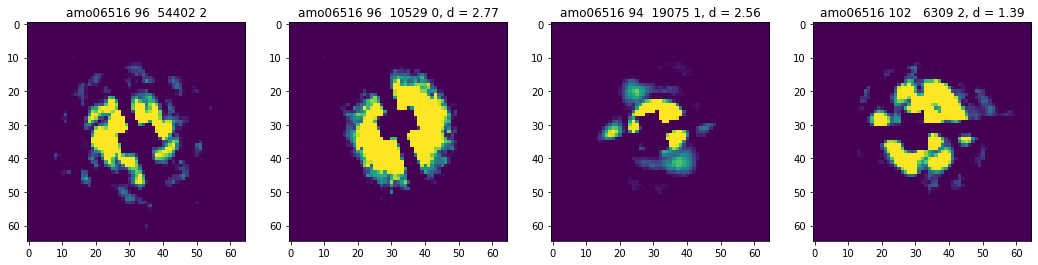

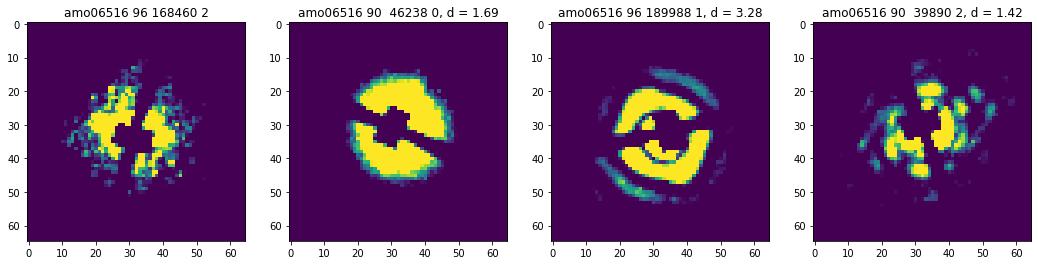

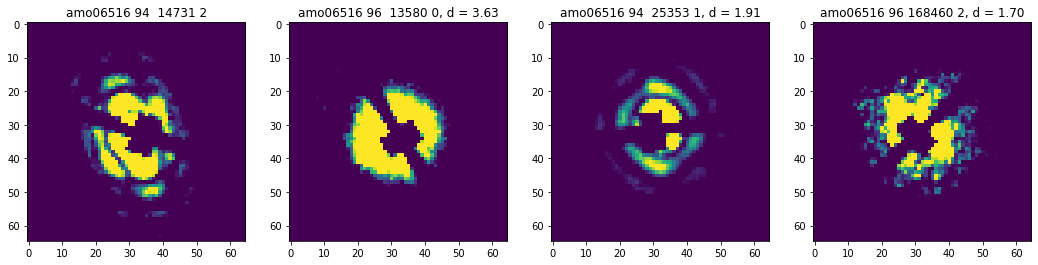

In [74]:
# Sample from the min embedding distance distribution
value_to_sample = 1.5
window_size = 0.25
selection_mask = np.logical_and(value_to_sample - window_size < min_value_list, min_value_list < value_to_sample + window_size)
selection_tuple = np.argwhere(selection_mask)    # (idx_batch, idx_example)
print(f"Total events = {len(selection_tuple)}")
num_example_in_batch = len(batch_metadata_query_list[0][0])
for idx_batch, idx_example in selection_tuple[:10]:
    fig = plt.figure(figsize=(18,6))

    nrows = 1
    ncols = 4
    gspec = fig.add_gridspec( nrows, ncols,
                              width_ratios  = [1, 1, 1, 1],
                              #height_ratios = [1, 1/25],
                            )
    ax_list  = [ fig.add_subplot(gspec[0, i]) for i in range(ncols) ]
    #ax_list += [ fig.add_subplot(gspec[1, i]) for i in range(ncols) ]

    idx_query = idx_batch * num_example_in_batch + idx_example
    img_query = dataset_test[idx_query][0]
    
    #img_support_chosen = dataset_test[idx_query][idx_support_chosen]
    img_support_list = dataset_test[idx_query][1:1+3]
    
    data = img_query[0]
    vmin = data.mean()
    vmax = vmin + 1 * data.std()
    im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)
    #plt.colorbar(im, cax = ax_list[2], orientation="horizontal", pad = 0.05)
    metadata_query = batch_metadata_query_list[idx_batch][0][idx_example]
    ax_list[0].set_title(metadata_query)

    for idx_support, img_support in enumerate(img_support_list):
        data = img_support[0]
        vmin = data.mean()
        vmax = vmin + 1 * data.std()
        im = ax_list[idx_support+1].imshow(data, vmin = vmin, vmax = vmax)   
        #plt.colorbar(im, cax = ax_list[3], orientation="horizontal", pad = 0.05)
        metadata_support = batch_metadata_support_list[idx_batch][idx_support][idx_example]
        dist_support = batch_dist_support_list[idx_batch][idx_support][idx_example]
        ax_list[idx_support+1].set_title(f"{metadata_support}, d = {dist_support:.2f}")

##### Back to confusion matrix

In [22]:
batch_metadata_support_selected_list = []
for idx_batch in range(len(batch_metadata_support_list)):
    metadata_support_selected_list = []
    for idx_example in range(len(batch_metadata_support_list[0][0])):
        idx_min_value = idx_min_value_list[idx_batch][idx_example]
        metadata_support_selected = batch_metadata_support_list[idx_batch][idx_min_value][idx_example]
        metadata_support_selected_list.append(metadata_support_selected)
    batch_metadata_support_selected_list.append(metadata_support_selected_list)

In [23]:
class MacroMetric:
    def __init__(self, res_dict):
        self.res_dict = res_dict


    def reduce_confusion(self, label):
        ''' Given a label, reduce multiclass confusion matrix to binary
            confusion matrix.
        '''
        res_dict    = self.res_dict
        labels      = res_dict.keys()
        labels_rest = [ i for i in labels if not i == label ]

        # Early return if non-exist label is passed in...
        if not label in labels: 
            print(f"label {label} doesn't exist!!!")
            return None

        # Obtain true positive...
        tp = len(res_dict[label][label])
        fp = sum( [ len(res_dict[label][i]) for i in labels_rest ] )
        tn = sum( sum( len(res_dict[i][j]) for j in labels_rest ) for i in labels_rest )
        fn = sum( [ len(res_dict[i][label]) for i in labels_rest ] )

        return tp, fp, tn, fn


    def get_metrics(self, label):
        # Early return if non-exist label is passed in...
        confusion = self.reduce_confusion(label)
        if confusion is None: return None

        # Calculate metrics...
        tp, fp, tn, fn = confusion
        accuracy    = (tp + tn) / (tp + tn + fp + fn)
        precision   = tp / (tp + fp)
        recall      = tp / (tp + fn)
        specificity = tn / (tn + fp) if tn + fp > 0 else None
        f1_inv      = (1 / precision + 1 / recall)
        f1          = 2 / f1_inv

        return accuracy, precision, recall, specificity, f1


In [24]:
labels = set([ metadata.split()[-1] for batch_metadata in batch_metadata_query_list for metadata in batch_metadata[0] ])
labels

{'0', '1', '2'}

In [25]:
# New container to store validation result (thus res_dict) for each label...
res_dict = {}
for label in labels: res_dict[label] = { i : [] for i in labels }

In [26]:
for idx_batch in range(len(batch_metadata_support_list)):
    for idx_example in range(len(batch_metadata_query_list[idx_batch][0])):
        metadata_true = batch_metadata_query_list[idx_batch][0][idx_example]
        metadata_pred = batch_metadata_support_selected_list[idx_batch][idx_example]
        label_true = metadata_true.split()[-1]
        label_pred = metadata_pred.split()[-1]
        res_dict[label_pred][label_true].append( (metadata_true, metadata_pred) )

In [27]:
# Get macro metrics...
macro_metric = MacroMetric(res_dict)

# Formating purpose...
disp_dict = { "0" : "not-sample",
              "1" : "single-hit",
              "2" : " multi-hit",
              "9" : "background",
            }

# Report multiway classification...
msgs = []
for label_pred in labels:
    disp_text = disp_dict[label_pred]
    msg = f"{disp_text}  |"
    for label_real in labels:
        num = len(res_dict[label_pred][label_real])
        msg += f"{num:>12d}"

    metrics = macro_metric.get_metrics(label_pred)
    for metric in metrics:
        msg += f"{metric:>12.2f}"
    msgs.append(msg)

msg_header = " " * (msgs[0].find("|") + 1)
for label in labels: 
    disp_text = disp_dict[label]
    msg_header += f"{disp_text:>12s}"

for header in [ "accuracy", "precision", "recall", "specificity", "f1" ]:
    msg_header += f"{header:>12s}"
print(msg_header)

msg_headerbar = "-" * len(msgs[0])
print(msg_headerbar)
for msg in msgs:
    print(msg)

               not-sample  single-hit   multi-hit    accuracy   precision      recall specificity          f1
-------------------------------------------------------------------------------------------------------------
not-sample  |         329           0           2        1.00        0.99        1.00        1.00        1.00
single-hit  |           0         330          18        0.98        0.95        0.98        0.97        0.96
 multi-hit  |           0           6         315        0.97        0.98        0.94        0.99        0.96


In [28]:
timestamp_test

'2022_1114_0123_11'

#### Source/Sample the wrong prediction

pred, true

In [41]:
res_dict['1']['2']

[('amo06516 94  39872 2', 'amo06516 96 131163 1'),
 ('amo06516 94  28977 2', 'amo06516 102   6025 1'),
 ('amo06516 96  41743 2', 'amo06516 94  20143 1'),
 ('amo06516 96  41743 2', 'amo06516 94   1498 1'),
 ('amo06516 94  39872 2', 'amo06516 94  33115 1'),
 ('amo06516 96  41743 2', 'amo06516 96  68445 1'),
 ('amo06516 96  79300 2', 'amo06516 96 188115 1'),
 ('amo06516 96   5389 2', 'amo06516 91  40272 1'),
 ('amo06516 96  41743 2', 'amo06516 91  66565 1'),
 ('amo06516 102   6309 2', 'amo06516 94  12388 1'),
 ('amo06516 94  43737 2', 'amo06516 90  28756 1'),
 ('amo06516 96  41743 2', 'amo06516 94  25353 1'),
 ('amo06516 96   5389 2', 'amo06516 96 183207 1'),
 ('amo06516 96   5389 2', 'amo06516 96 126517 1'),
 ('amo06516 96  41743 2', 'amo06516 96  81826 1'),
 ('amo06516 94  14894 2', 'amo06516 90  27152 1'),
 ('amo06516 96  41743 2', 'amo06516 90  48496 1'),
 ('amo06516 102   6574 2', 'amo06516 96 188115 1'),
 ('amo06516 96  41743 2', 'amo06516 94  43526 1'),
 ('amo06516 96   5389 2', 'a

In [52]:
# New container to store validation result (thus res_dict) for each label...
idx_res_dict = {}
for label in labels: idx_res_dict[label] = { i : [] for i in labels }

In [53]:
for idx_batch in range(len(batch_metadata_support_list)):
    for idx_example in range(len(batch_metadata_query_list[idx_batch][0])):
        metadata_true = batch_metadata_query_list[idx_batch][0][idx_example]
        metadata_pred = batch_metadata_support_selected_list[idx_batch][idx_example]
        label_true = metadata_true.split()[-1]
        label_pred = metadata_pred.split()[-1]
        idx_min_value = idx_min_value_list[idx_batch][idx_example]
        idx_res_dict[label_pred][label_true].append( (idx_batch, idx_example, idx_min_value) )

In [45]:
idx_res_dict['1']['2']

[(0, 18),
 (0, 79),
 (1, 8),
 (1, 50),
 (2, 7),
 (2, 54),
 (3, 16),
 (4, 21),
 (4, 78),
 (5, 39),
 (5, 66),
 (6, 1),
 (6, 40),
 (6, 55),
 (7, 30),
 (7, 92),
 (8, 1),
 (8, 58),
 (8, 85),
 (9, 30),
 (9, 76)]

/reg/data/ana03/scratch/cwang31/conda/ana-py3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


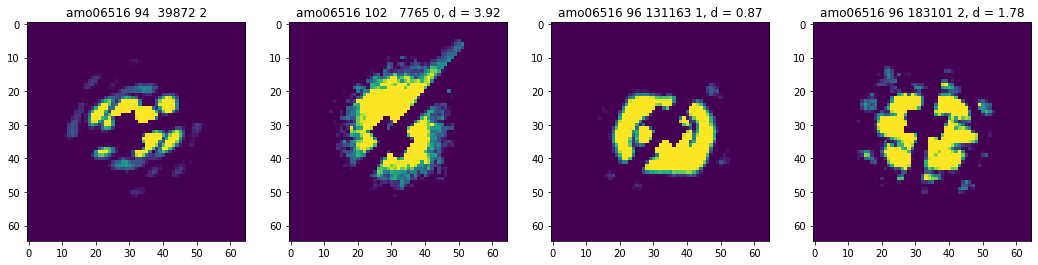

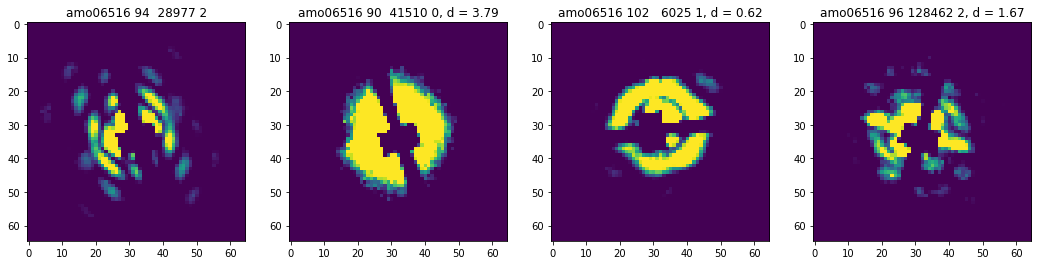

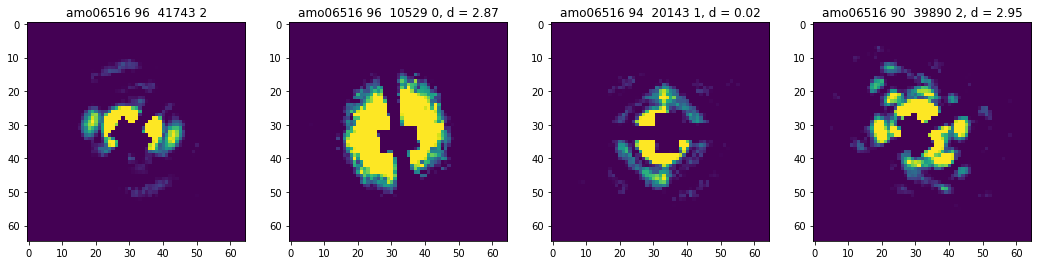

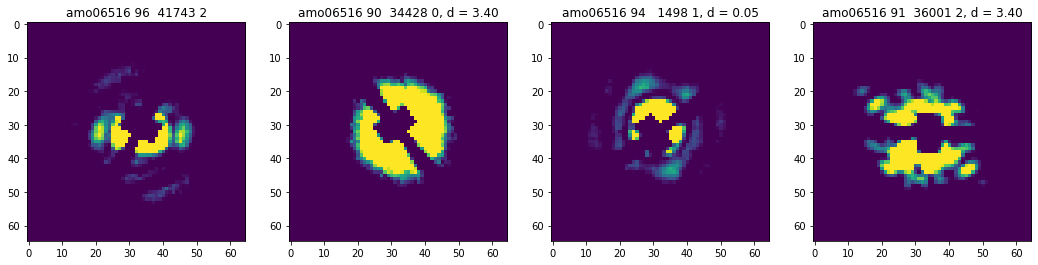

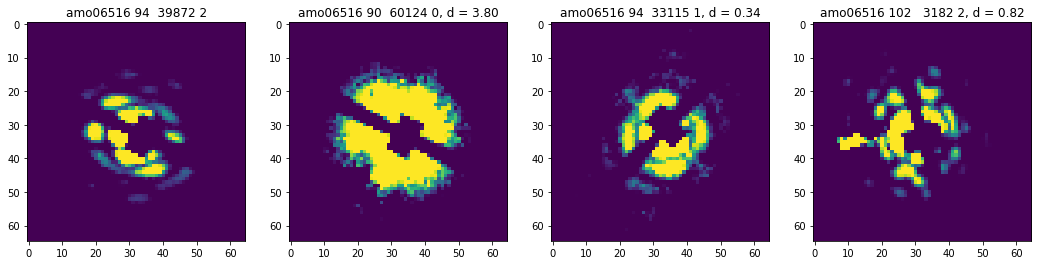

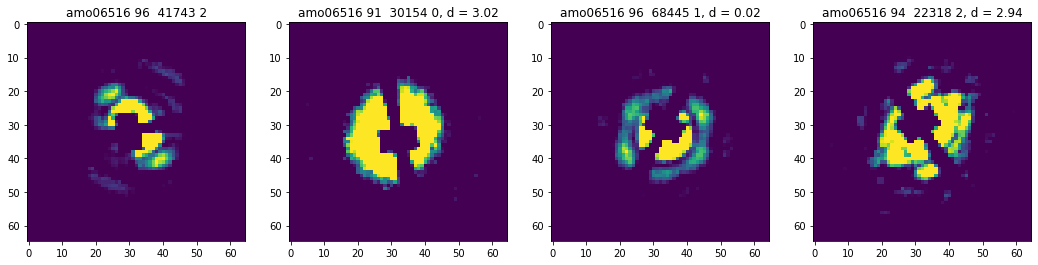

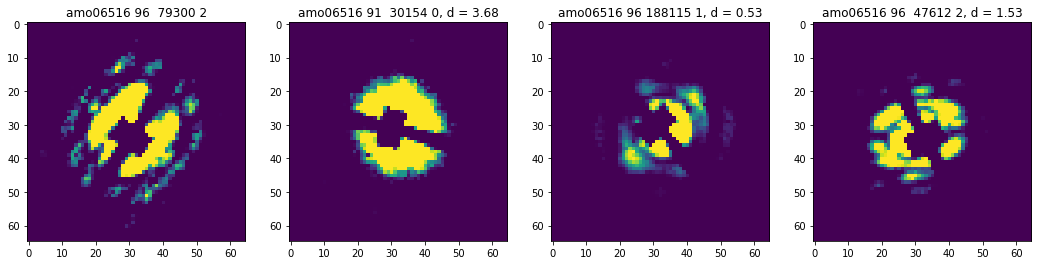

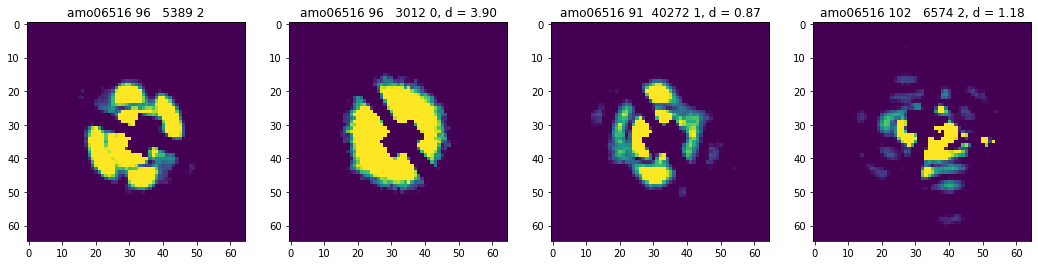

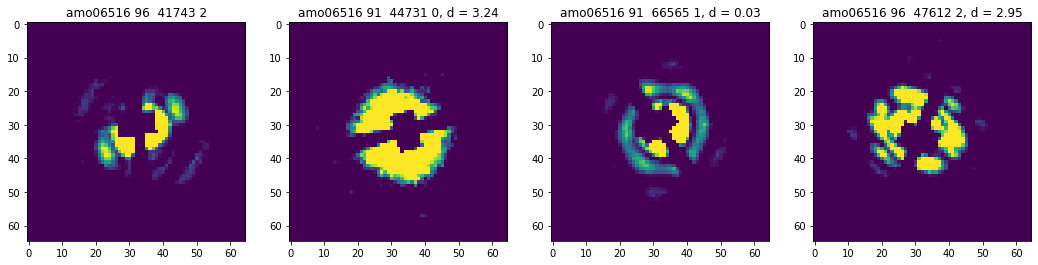

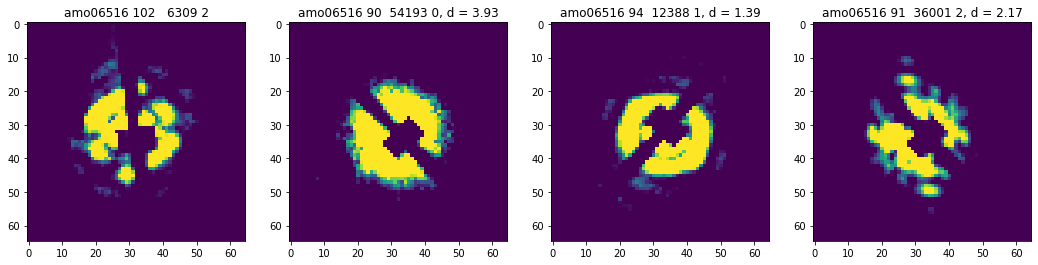

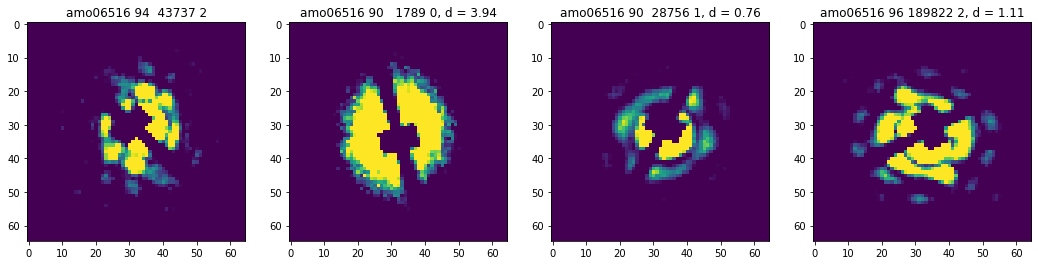

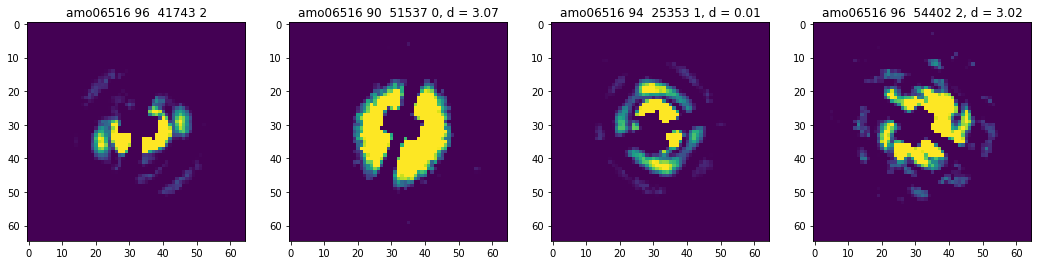

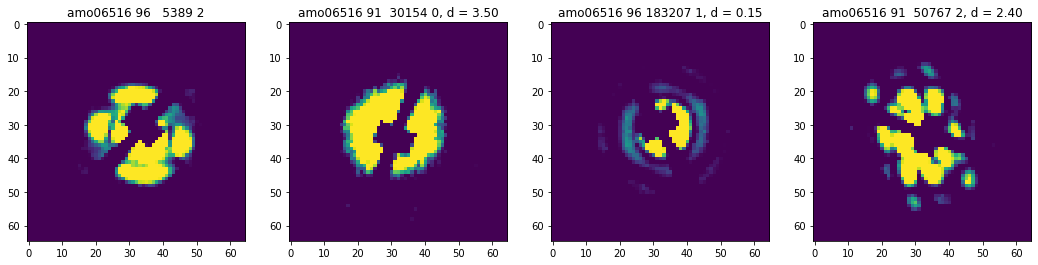

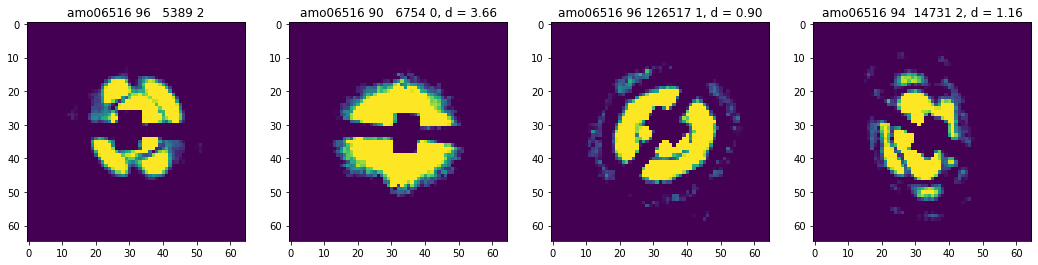

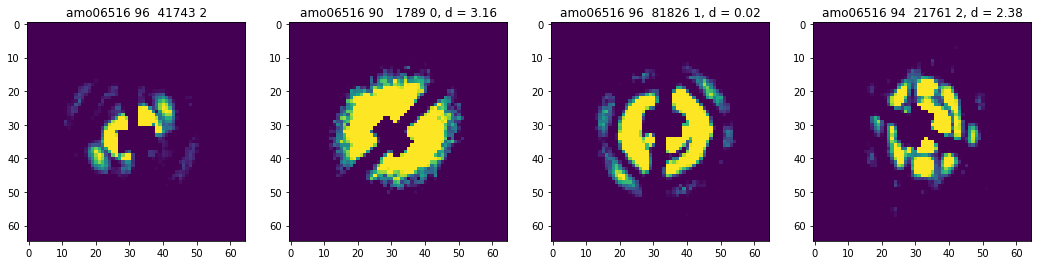

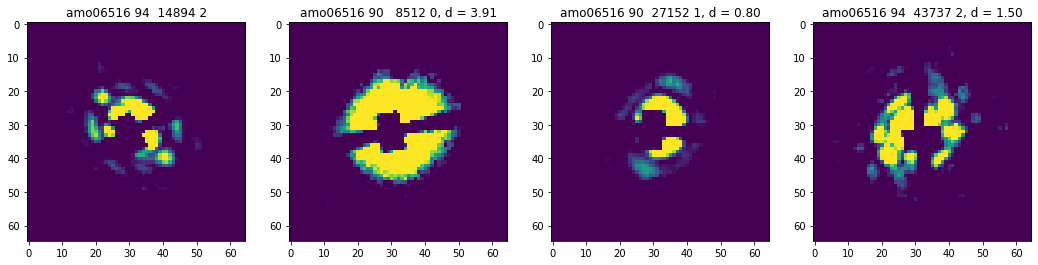

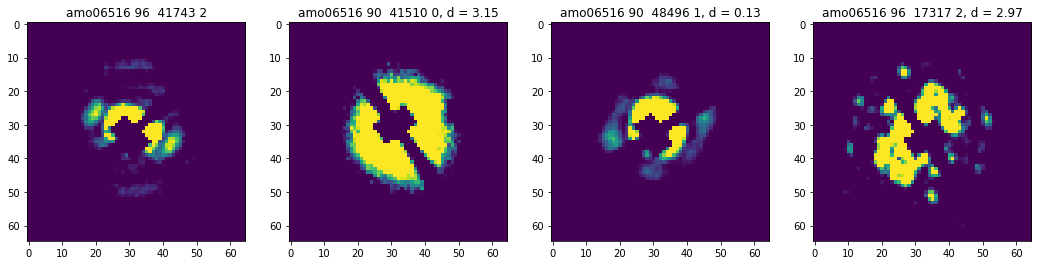

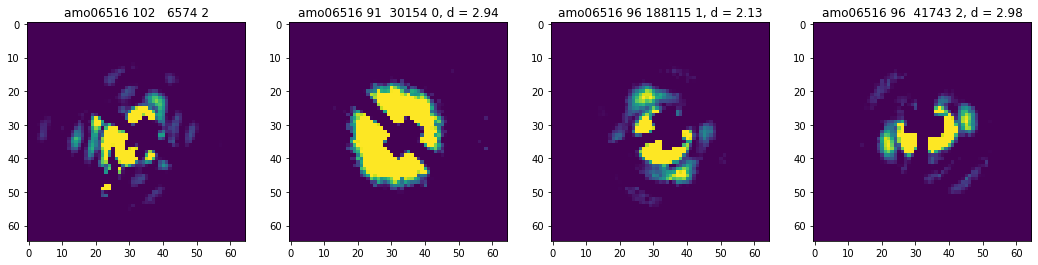

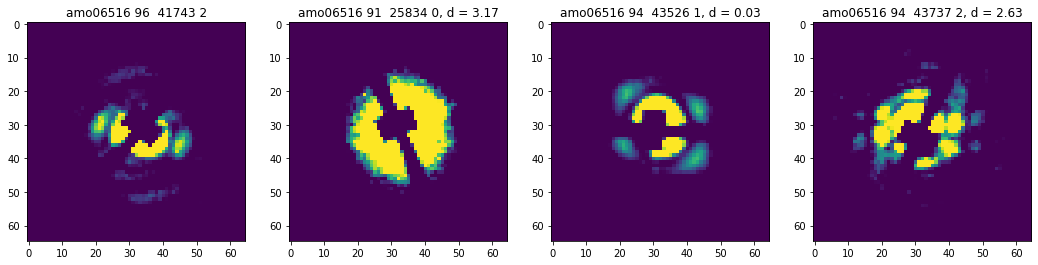

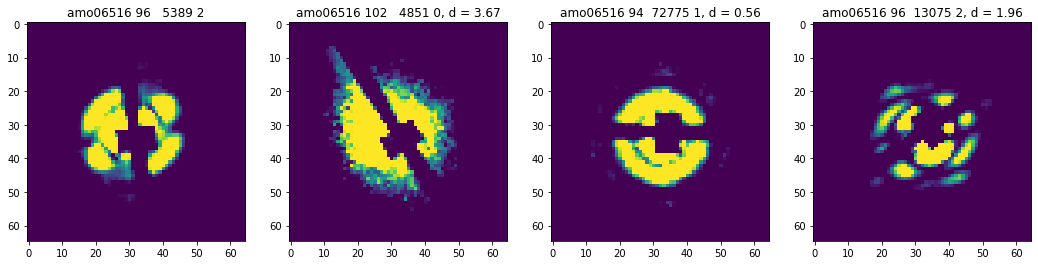

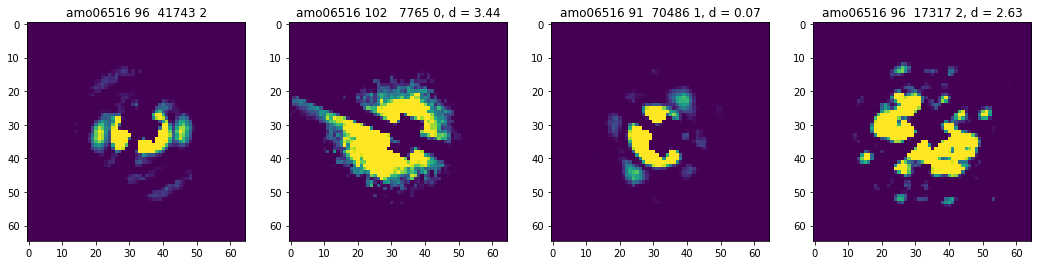

In [82]:
failed_test_list = idx_res_dict['1']['2']
num_example_in_batch = len(batch_metadata_query_list[0][0])
for idx_batch, idx_example, idx_support_chosen in failed_test_list[:]:
    fig = plt.figure(figsize=(18,6))

    nrows = 1
    ncols = 4
    gspec = fig.add_gridspec( nrows, ncols,
                              width_ratios  = [1, 1, 1, 1],
                              #height_ratios = [1, 1/25],
                            )
    ax_list  = [ fig.add_subplot(gspec[0, i]) for i in range(ncols) ]
    #ax_list += [ fig.add_subplot(gspec[1, i]) for i in range(ncols) ]

    idx_query = idx_batch * num_example_in_batch + idx_example
    img_query = dataset_test[idx_query][0]
    
    #img_support_chosen = dataset_test[idx_query][idx_support_chosen]
    img_support_list = dataset_test[idx_query][1:1+3]
    
    data = img_query[0]
    vmin = data.mean()
    vmax = vmin + 1 * data.std()
    im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)
    #plt.colorbar(im, cax = ax_list[2], orientation="horizontal", pad = 0.05)
    metadata_query = batch_metadata_query_list[idx_batch][0][idx_example]
    ax_list[0].set_title(metadata_query)

    for idx_support, img_support in enumerate(img_support_list):
        data = img_support[0]
        vmin = data.mean()
        vmax = vmin + 1 * data.std()
        im = ax_list[idx_support+1].imshow(data, vmin = vmin, vmax = vmax)   
        #plt.colorbar(im, cax = ax_list[3], orientation="horizontal", pad = 0.05)
        metadata_support = batch_metadata_support_list[idx_batch][idx_support][idx_example]
        dist_support = batch_dist_support_list[idx_batch][idx_support][idx_example]
        ax_list[idx_support+1].set_title(f"{metadata_support}, d = {dist_support:.2f}")

#### Source/Sample the right prediction

pred, true

In [41]:
res_dict['1']['1']

[('amo06516 94  39872 2', 'amo06516 96 131163 1'),
 ('amo06516 94  28977 2', 'amo06516 102   6025 1'),
 ('amo06516 96  41743 2', 'amo06516 94  20143 1'),
 ('amo06516 96  41743 2', 'amo06516 94   1498 1'),
 ('amo06516 94  39872 2', 'amo06516 94  33115 1'),
 ('amo06516 96  41743 2', 'amo06516 96  68445 1'),
 ('amo06516 96  79300 2', 'amo06516 96 188115 1'),
 ('amo06516 96   5389 2', 'amo06516 91  40272 1'),
 ('amo06516 96  41743 2', 'amo06516 91  66565 1'),
 ('amo06516 102   6309 2', 'amo06516 94  12388 1'),
 ('amo06516 94  43737 2', 'amo06516 90  28756 1'),
 ('amo06516 96  41743 2', 'amo06516 94  25353 1'),
 ('amo06516 96   5389 2', 'amo06516 96 183207 1'),
 ('amo06516 96   5389 2', 'amo06516 96 126517 1'),
 ('amo06516 96  41743 2', 'amo06516 96  81826 1'),
 ('amo06516 94  14894 2', 'amo06516 90  27152 1'),
 ('amo06516 96  41743 2', 'amo06516 90  48496 1'),
 ('amo06516 102   6574 2', 'amo06516 96 188115 1'),
 ('amo06516 96  41743 2', 'amo06516 94  43526 1'),
 ('amo06516 96   5389 2', 'a

In [83]:
# New container to store validation result (thus res_dict) for each label...
idx_res_dict = {}
for label in labels: idx_res_dict[label] = { i : [] for i in labels }

In [84]:
for idx_batch in range(len(batch_metadata_support_list)):
    for idx_example in range(len(batch_metadata_query_list[idx_batch][0])):
        metadata_true = batch_metadata_query_list[idx_batch][0][idx_example]
        metadata_pred = batch_metadata_support_selected_list[idx_batch][idx_example]
        label_true = metadata_true.split()[-1]
        label_pred = metadata_pred.split()[-1]
        idx_min_value = idx_min_value_list[idx_batch][idx_example]
        idx_res_dict[label_pred][label_true].append( (idx_batch, idx_example, idx_min_value) )

In [45]:
idx_res_dict['1']['2']

[(0, 18),
 (0, 79),
 (1, 8),
 (1, 50),
 (2, 7),
 (2, 54),
 (3, 16),
 (4, 21),
 (4, 78),
 (5, 39),
 (5, 66),
 (6, 1),
 (6, 40),
 (6, 55),
 (7, 30),
 (7, 92),
 (8, 1),
 (8, 58),
 (8, 85),
 (9, 30),
 (9, 76)]

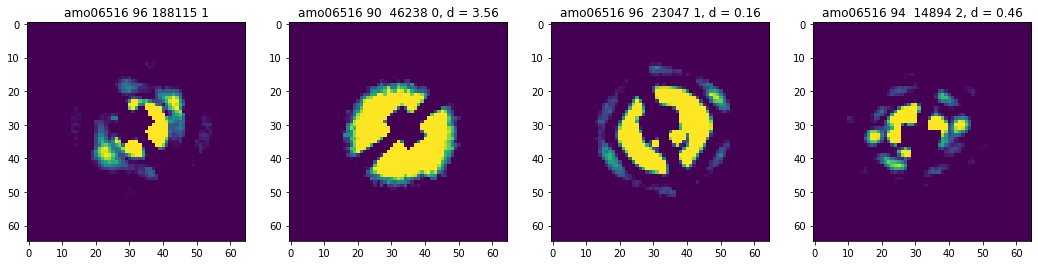

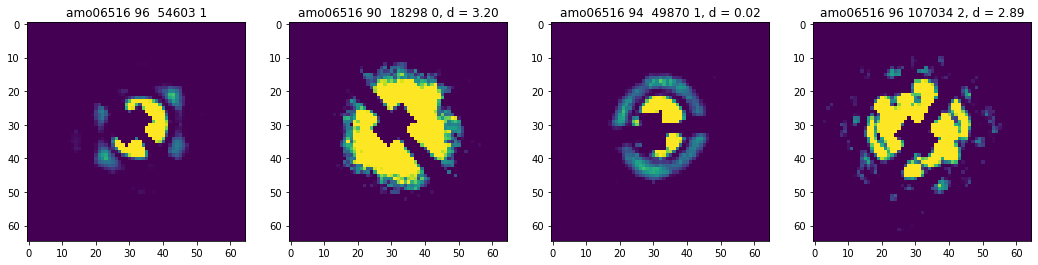

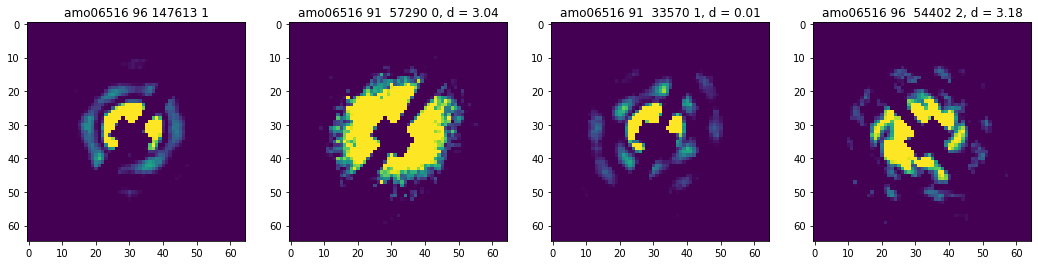

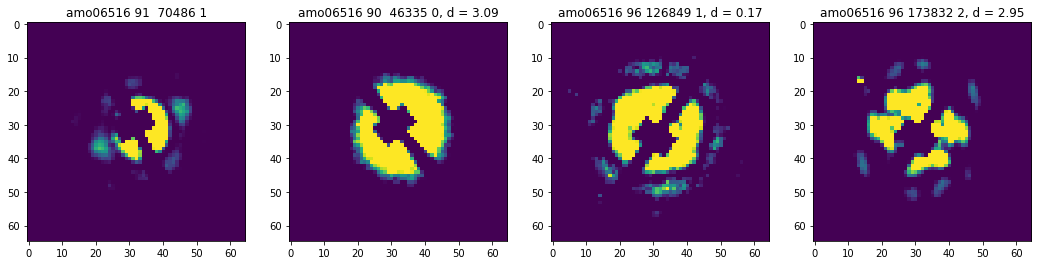

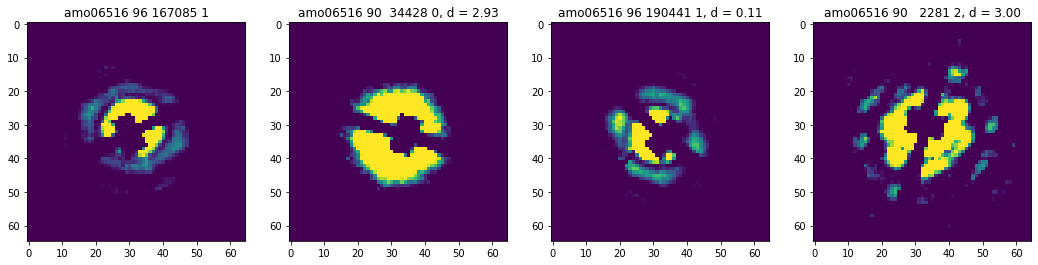

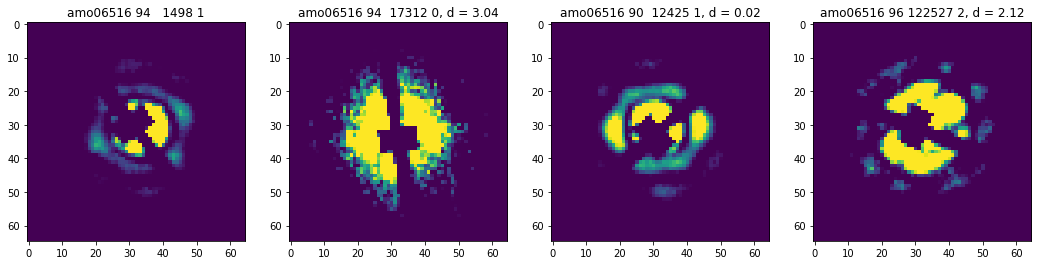

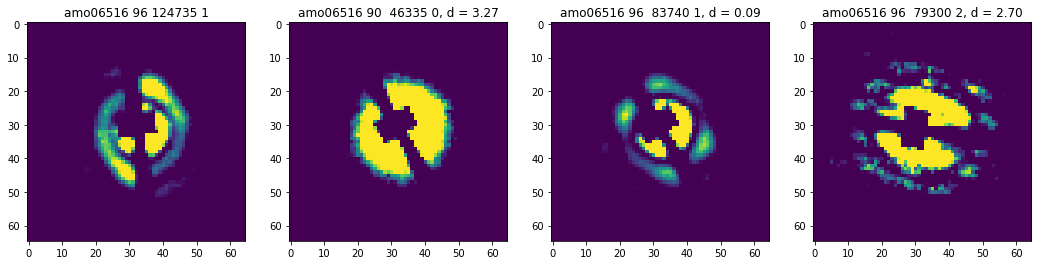

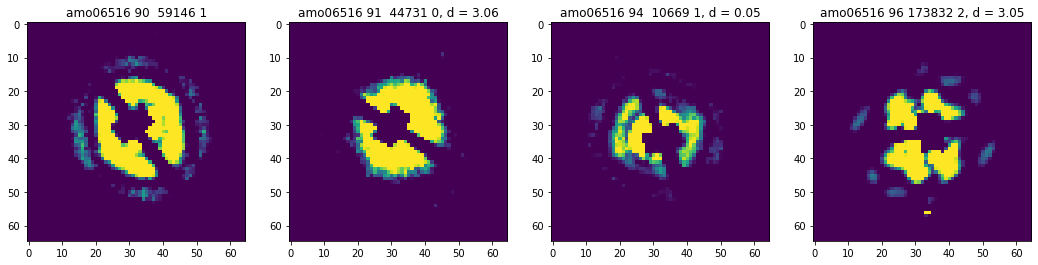

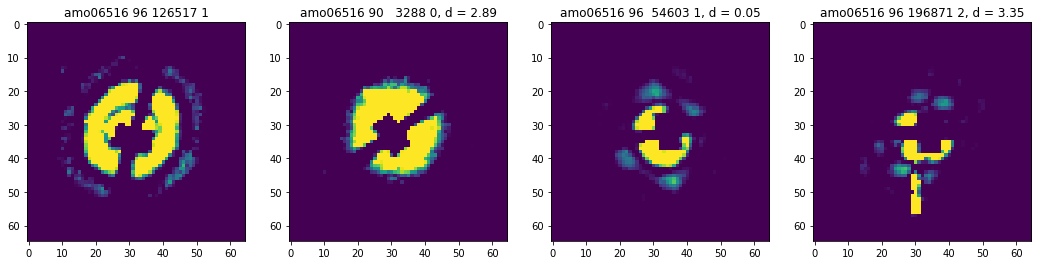

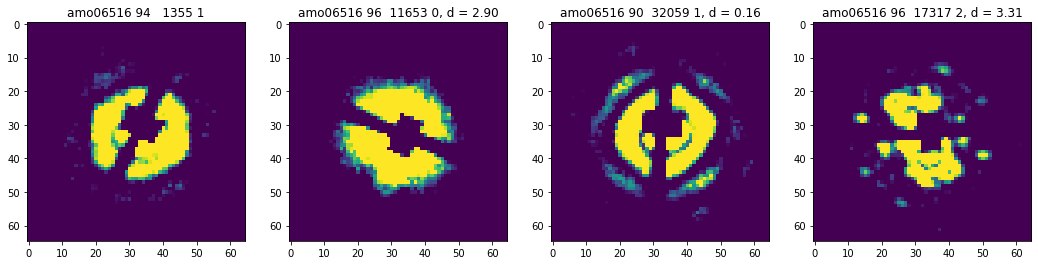

In [85]:
test_list = idx_res_dict['1']['1']
num_example_in_batch = len(batch_metadata_query_list[0][0])
for idx_batch, idx_example, idx_support_chosen in test_list[:10]:
    fig = plt.figure(figsize=(18,6))

    nrows = 1
    ncols = 4
    gspec = fig.add_gridspec( nrows, ncols,
                              width_ratios  = [1, 1, 1, 1],
                              #height_ratios = [1, 1/25],
                            )
    ax_list  = [ fig.add_subplot(gspec[0, i]) for i in range(ncols) ]
    #ax_list += [ fig.add_subplot(gspec[1, i]) for i in range(ncols) ]

    idx_query = idx_batch * num_example_in_batch + idx_example
    img_query = dataset_test[idx_query][0]
    
    #img_support_chosen = dataset_test[idx_query][idx_support_chosen]
    img_support_list = dataset_test[idx_query][1:1+3]
    
    data = img_query[0]
    vmin = data.mean()
    vmax = vmin + 1 * data.std()
    im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)
    #plt.colorbar(im, cax = ax_list[2], orientation="horizontal", pad = 0.05)
    metadata_query = batch_metadata_query_list[idx_batch][0][idx_example]
    ax_list[0].set_title(metadata_query)

    for idx_support, img_support in enumerate(img_support_list):
        data = img_support[0]
        vmin = data.mean()
        vmax = vmin + 1 * data.std()
        im = ax_list[idx_support+1].imshow(data, vmin = vmin, vmax = vmax)   
        #plt.colorbar(im, cax = ax_list[3], orientation="horizontal", pad = 0.05)
        metadata_support = batch_metadata_support_list[idx_batch][idx_support][idx_example]
        dist_support = batch_dist_support_list[idx_batch][idx_support][idx_example]
        ax_list[idx_support+1].set_title(f"{metadata_support}, d = {dist_support:.2f}")